<p style="text-align:center;">
    <img src="img/snps_logo.png" alt="drawing" style="width:120px;"/>
</p>

# **Model Deployment Tutorial for TensorFlow and EMNIST**
This file guides you through the porting process of the Keras model (with TensorFlow 2.0 backend) for usage with the embARC Machine Learning Inference Library (embARC MLI). 
<br>
This process proceeds in the following three stages:

1. Define and initialize the model with pretrained weights.
2. Deploy the trained model by processing all the information about the model to create its MLI representation.
3. Integrate the deployed model into application. 
<br> 
<p style="text-align:center;">
    <img src="img/depl_process.png" alt="drawing" style="width:600px;"/>
</p>
<br> 

After completion of this tutorial you have all the required files for running the described graph on the Synopsys ARC processor.

In [2]:
import warnings
import widgets_def
# from keras_tqdm import TQDMNotebookCallback
from IPython.display import display

import tensorflow as tf
from tensorflow import keras
    
print(tf.__version__)

2.5.0


## Create Keras model

### **Load and preprocess dataset**

EMNIST dataset containing 62 classes in total is used for this tutorial. Each sample is a 28x28 grayscale image similar to MNIST. Class structure is shown below:

    EMNIST ByClass: 814,255 characters. 62 unbalanced classes.
    EMNIST ByMerge: 814,255 characters. 47 unbalanced classes.
    EMNIST Balanced:  131,600 characters. 47 balanced classes.
    EMNIST Letters: 145,600 characters. 26 balanced classes.
    EMNIST Digits: 280,000 characters. 10 balanced classes.
    EMNIST MNIST: 70,000 characters. 10 balanced classes.

[EMNIST article](https://arxiv.org/pdf/1702.05373.pdf)

Only 'letters' dataset is used for this tutorial. 

To load it as a numpy array using 'emnist' module, use the following code.

<div class="alert alert-block alert-danger">
<b>WARNING:</b> If you see empty plots during the preprocess steps, check if you have executed one of the cells several times. If so, run the preprocessing steps one more time starting from the cell below.
</div>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from emnist import extract_training_samples, extract_test_samples

X_train, y_train = extract_training_samples('letters')
X_test, y_test = extract_test_samples('letters')

# Make class numbering start at 0
y_train = y_train - 1
y_test = y_test - 1

img_rows, img_cols = X_train.shape[1], X_train.shape[2]
num_classes = len(np.unique(y_train))

print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)
print('Image height: ', img_rows)
print('Image width: ', img_cols)
print('Classes: ', num_classes)

X_train:  (124800, 28, 28)
X_test:  (20800, 28, 28)
Image height:  28
Image width:  28
Classes:  26


Print a sample for each class from X_train to make sure that it loads correctly:

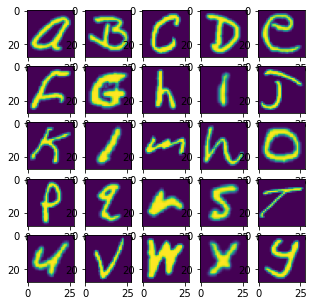

In [4]:
y_unique, unique_indices = np.unique(y_train, return_index=True)

fig=plt.figure(figsize=(5, 5))
cols = 5
rows = 5
for plt_idx, img_idx in enumerate(unique_indices[:rows*cols], 1):
    img = X_train[img_idx]
    fig.add_subplot(rows, cols, plt_idx)
    plt.imshow(img)
plt.show() 

Each letter needs to be represented as a number, as neural networks work with numerical data. **One-hot encoding** is a representation of categorical data as a binary vector. In the example vector below there are only 4 distinct letters 'a', 'b', 'c' and 'd': 
<center>
    <span style="font-family:Courier; font-size:1em;">
    <br>
    letters = ['a', 'b', 'c', 'd', 'a', 'd', 'c']
    </span>
</center>

Each letter can be represented as:
<center>
    <span style="font-family:Courier; font-size:1em;">
    <br>
    'a' -> [1, 0, 0, 0]
    <br>
    'b' -> [0, 1, 0, 0]
    <br>
    'c' -> [0, 0, 1, 0]
    <br>
    'd' -> [0, 0, 0, 1]
    <br>
    </span>
</center>

Thus, `letters` vector becomes a matrix:
<center>
    <span style="font-family:Courier; font-size:1em;">
    <br>
    letters =
    <br>
           'a'  [1, 0, 0, 0]  
    <br>
           'b'  [0, 1, 0, 0]  
    <br>
           'c'  [0, 0, 1, 0]  
    <br>
           'd'  [0, 0, 0, 1]  
    <br>
           'a'  [1, 0, 0, 0]  
    <br>
           'd'  [0, 0, 0, 1]  
    <br>
           'c'  [0, 0, 1, 0] 
    <br>
    </span>
</center>


One-hot encoding can be applied to `y_train` and `y_test` (train and test labels respectively). During training, if the number of output neurons in our neural network is equal to the number of classes, the model tries to make the output vector look as similar as possible to the one-hot encoded label of the just propagated letter. To make this approximation, ensure that you scale the output values to [0..1] range, which can be done using `softmax` function as an activation of the last layer. 

`Softmax` function converts an arbitrary vector to a vector of probabilities depending on the size of each value in the arbitrary vector. Effectively, the model needs to be trained to output a vector with 1 in a place corresponding to the current input letter.  
<center>
    <span style="font-family:Courier; font-size:1em;">
    <br>
    y_test[0] = [1, 0, 0, 0, 0, 0, 0]
    <br>
    output = [0.98, 0.04, 0.17, 0.01, 0.02, 0.08, 0.22]
    <br>
    </span>
</center>

`y_test[0]` - is a one-hot encoded label of the first sample from the test dataset, `output` - result of propagation of `X_test[0]` sample through the network. With this output it's very likely, that the input to the model was a letter 'a'. 

You can implement one-hot encoding using `keras.utils.to_categorical`. Since 'channel last' mode is the default mode for training with CPU in TensorFlow, reshape train and test dataset as shown in the following code:

X_train:  (124800, 28, 28, 1)
y_train_cat:  (124800, 26)

Image and categorical representation of sample #20: 
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


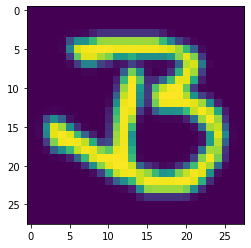

In [5]:
from tensorflow.keras.utils import to_categorical

X_train = X_train.reshape([X_train.shape[0], img_rows, img_cols, 1])
X_test = X_test.reshape([X_test.shape[0], img_rows, img_cols, 1])

y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print('X_train: ', X_train.shape)
print('y_train_cat: ', y_train_cat.shape)

print('\nImage and categorical representation of sample #20: ')
plt.imshow(X_train[20][:,:,0])
print(y_train_cat[20])

Letters from the dataset and the input data taken from the board are different. Each letter in the dataset has different levels of brightness, depending on how close a particular pixel is to the edge. While, all the letters in the dataset look as if they were written on paper, the board input considers only the shape of the line without considering the pressure level or the angle of writing. 

To make predictions more accurate, add another preprocessing for each image, which applies binarization to the dataset:

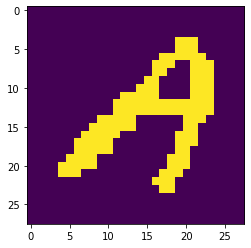

In [6]:
def thinning(image):
    tmp = np.where(image < 210.0, 0, image)
    return np.where(tmp > 210.0, 255, tmp)

X_train = thinning(X_train)
X_test = thinning(X_test)

plt.imshow(X_test[100][:,:,0])

Normalize values by subtracting the average and dividing by average. The range of values becomes [-1.0, 1.0]

In [7]:
X_train_orig = X_train
X_test_orig = X_test

X_train = (X_train - 128.0) / 128.0 
X_test = (X_test - 128.0) / 128.0

print('X_train: ', X_train.shape)
print('y_train_cat: ', y_train_cat.shape)

X_train:  (124800, 28, 28, 1)
y_train_cat:  (124800, 26)


### **Model definition**
Model structure is shown in the following figure:

<p style="text-align:center;">
    <img src="img/graph2.png" alt="drawing" style="width:1200px;"/>
</p>

Model consisits of multiple convolution, pooling, and fully connected layers. Batch normalization is applied to each convolution and FC layer, except the last one. Softmax activation outputs probabilities for each class. 

Pre-trained weights and biases are provided in the same folder as this tutorial in HDF5 format (`mli_cnn_bn.h5`). HDF5 file stores multidimensional numpy arrays very efficiently to store large parameter tensors of each layer.

To load weights and biases, define structure of the model manually as shown in the following code:

In [8]:
filter_x = 5
filter_y = 5

In [9]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense
from tensorflow.keras.layers import Activation, BatchNormalization, Flatten
from tensorflow.keras.models import Sequential


input_shape = (img_rows, img_cols, 1)

model = Sequential()

#Conv1
model.add(Conv2D(filters=16, 
                 kernel_size=(filter_x, filter_y), 
                 padding="same",  
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D())

#Conv2
model.add(Conv2D(filters=32, 
                 kernel_size=(filter_x, filter_y), 
                 padding="same", 
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D())

#Conv3
model.add(Conv2D(filters=32, 
                 kernel_size=(filter_x, filter_y), 
                 padding="same", 
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D())

#FC1
model.add(Flatten())
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation("relu"))

#FC2
model.add(Dense(num_classes))
model.add(Activation("softmax"))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        416       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 28, 28, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        12832     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 32)        0

By choosing proper radio buttons, you can either 
 * load the weights using `model.load_weights('mli_cnn_bn.h5')`, or
 * train the model from scratch . Training includes updating the model weights in accordance with `X_train` dataset. 

The entire `X_train` dataset can be used more that once to update the weights. Every time the dataset is propagated, it updates the weights from the previous propagation. That results in accurate estimates of weights and precise model evaluations.   

To obtain an initial low-accuracy estimate, propagate the `X_train` dataset just once. 

Traditionally, weights are updated using each sample from `X_train` individually during one epoch. This is time-consuming, since update on every step can vary significantly and might miss the optimal value. On the other hand, the entire dataset can be used for update (batch training). This saves time, but requires a lot of memory and affects accuracy, since dataset averages are used for update. A compromise approach "mini-batch training" uses subsets of `X_train` to update weights which makes the estimates more stable, while requiring lesser memory space.

<p style="text-align:center;">
    <img src="img/mini_batch.png" alt="drawing" style="width:300px;"/>
</p>

Increasing the number of epochs increases the model accuracy until some point, but this requires more time. 
Increasing the batch size speeds up the process, but can result in model degradation if it is too large.  

<div class="alert alert-block alert-info">
You can choose the number of training epochs and batch size by using the two sliders which appear after running the cell below. 
</div>

In [10]:
display(widgets_def.batch_slider)
display(widgets_def.epochs_slider)

IntSlider(value=128, continuous_update=False, description='Batch size:', max=1000, min=1)

IntSlider(value=1, continuous_update=False, description='Epochs:', max=20, min=1)

<div class="alert alert-block alert-info">
Before executing subsequent cells, you can choose to either train the model or use pretrained weights with the button below.
</div>

In [11]:
display(widgets_def.train_radio)

RadioButtons(options=('Use Synopsys weights', 'Train and load custom weights', 'Load custom weights'), value='…

<div class="alert alert-block alert-danger">
If you chose to train the network, wait for the completion of training after running the next cell.
</div>

In [12]:
if(widgets_def.train_radio.value == 'Use Synopsys weights'):
    model.load_weights('mli_cnn_bn.h5')  
elif(widgets_def.train_radio.value == 'Train and load custom weights'):
    batch_size = widgets_def.batch_slider.value
    epochs = widgets_def.epochs_slider.value
    history = model.fit(X_train, y_train_cat, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=0,  
                    validation_data=(X_test, y_test_cat), 
                    shuffle=False,
                    callbacks=[TQDMNotebookCallback()])
    model.save_weights('mli_cnn_bn_custom.h5')
else:
    model.load_weights('mli_cnn_bn_custom.h5')

print('Done')
print('Weights shape of Conv_1 layer: ', model.get_weights()[0].shape)

Done
Weights shape of Conv_1 layer:  (5, 5, 1, 16)


### **Model evaluation**
To ensure that the model was initialized correctly, run the model on a test dataset and check that accuracy is around 90%.

In [13]:
scores = model.evaluate(X_test, y_test_cat, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 91.77%


## Keras model deployment
This section deals with steps for porting the model to MLI, as shown in the following figure:
<br>
<br>
<p style="text-align:center;">
    <img src="img/depl_steps.png" alt="drawing" style="width:700px;"/>
</p>
<br>

For better readability some functions have been moved to `emnist_keras_deployment` module. The structure of the notebook is as follows:

* **deployment_steps.py - contains function wrappers for usage inside this notebook**
    * generate_model_files(...) - wrapper, that calls file-generating functions from `file_writer.py`  
    * set_constants(...) - used in the beginning of deployment process to reduce the number of passed paramers to each function after it.
    * define_qmn(...) - outputs the number of bits, allocated for each model parameter when running with MLI
 
 
* **file_writer.py - contains functions, responsible for generating .h/.c files, describing the model in MLI terms, based on numpy arrays with preprocessed weights and biases of Keras model**

* **mli_fxtools.py - contains inner tensor representation class, for more convenient quantization**
* **constants.py - contains parts of source code for more convenient file generation**

### **Quantization**

To fit the model into ARC EM processor memory, perform quantization of each numerical value that describes the model or data. Quantization is the conversion of a float value to an assymetric or fixed-point data format so that it takes up less memory.

Consider a number, as shown in the following figure:

<br>
<p style="text-align:center;">
    <img src="img/quantization.png" alt="drawing" style="width:700px;"/>
</p>
<br>

Using fixed-point representation, 
 * memory can be saved by using fixed number of bits for representing a value, and 
 * Accuracy might be degraded, hence it can be restored by moving the decimal point. 
 **Since this number has no integer part, more bits can be used for fractional part to make the representation more accurate**. 

The following number cannot be represented in a more accurate way, since moving the point to the left destroys the information about its integer part:

<br>
<p style="text-align:center;">
    <img src="img/quantization2.png" alt="drawing" style="width:700px;"/>
</p>
<br>

Using 8 bits for a new number representation, **it is possible to fit x4 more numbers into ARC processor memory**.

### **Instrument model**

You have several ways to deploy the model:

* When you select the kernel type, define how many bits are allocated on ARC for each numerical value:

    * `sa8` - weights, biases and data are stored as asymmetric 8-bit values. It affects accuracy, since the 8-bit block value range and granularity might not be enough for an accurate data representation. This requires less memory. 
    * `fx16` - weights, biases and data are stored as 16-bit fixed-point values. It's more accurate than `sa8`, but requires 2x more memory 
    * `fx8w16d` - weights and biases are stored as 8-bit fixed-point values, data are stored as 16-bit fixed-point values.
    
* When you select `Debug version`, the script generates a version of the model to run in nSIM simulator. Additional code is generated to test each model layer on inference with output to the terminal. Otherwise, script outputs a minimal version to run on ARC processor. 

**Check `Debug version` to see additional debug information for each inference in cost of memory, performance and execution time in a simulator**

Change the kernel type to adjust the accuracy and size depending on your requirement. Letter classification is a simple task, and most of the time the model is sure about its prediction. This results in a big difference in probabilities for the right letters and the wrong ones, thereby allowing the usage of `sa8` with reduced accuracy.

In [14]:
display(widgets_def.kernel_type_toggle)
display(widgets_def.debug_version_checkbox)

ToggleButtons(description='Kernel type:', options=('fx8', 'fx16', 'fx8w16d'), value='fx8')

Checkbox(value=False, description='Debug version')

In [15]:
import emnist_keras_deployment.deployment_steps as deployment
import emnist_keras_deployment.constants as constants

frac_bits = 7
offset = 128.0

#Constants are set to reduce the number of parameters passed in the future
deployment.set_constants(
    prefix='emnist',
    num_classes=num_classes,
    kernel_type=widgets_def.kernel_type_toggle.value,
    debug=widgets_def.debug_version_checkbox.value,
    norm_value=offset,
    frac_bits=frac_bits,
    test_sample=1,
    ir_test_folder='idx',
    test_dataset_folder='small_test_base')

Constants set to: 


Prefix:  emnist
Num classes:  26
Kernel type:  fx16
Debug:  True
Offset:  128.0
Frac bits:  7
Test sample:  1
IR folder:  idx
Test dataset folder:  small_test_base




Collect weights, biases, inputs and outputs of each layer to perform quantization on them. Inputs and outputs of intermediate layers are collected using Keras backend. Since the model may use batch normalization, ensure that weights and biases of each layer previous to BatchNormalization layers are folded using next equations:

\begin{equation*}
W_{new} = \frac{\gamma W}{\sqrt{Var + \epsilon}} \quad \quad
b_{new} = \frac{\gamma (b - Mean)}{\sqrt{Var + \epsilon}} + \beta
\end{equation*}

where  $\gamma$ - learned scale,  $\beta$ - learned bias,  $Mean$ - mean, $Var$ - variance and $\epsilon$ - is a small constant included for numerical stability.

In [16]:
def collect_weights(model):
    weights = {}
    bias = {}
    for layer in model.layers:
        if isinstance(layer, (Conv2D, Dense)):
            weights[layer.name] = layer.get_weights()[0]
            bias[layer.name] = layer.get_weights()[1]
    
    return weights, bias

`fold_bn_to_weights` updates weights and bias of the layers previous to BatchNormalization, as BN layer is usually placed after Conv and Dense layers and before Activation layer. 

**To change the model, you must follow this rule**

In [17]:
def fold_bn_to_weights(model, weights, biases):
    eps = 1e-3
    prev_layer = None
    for layer in model.layers:
        if prev_layer:
            if isinstance(layer, BatchNormalization):
                gamma, beta, mean, var =  layer.get_weights()
            
                weights[prev_layer.name] = (gamma * weights[prev_layer.name]) / np.sqrt(var + eps)
                biases [prev_layer.name] = (gamma * (biases[prev_layer.name] - mean) / np.sqrt(var + eps)) + beta
        prev_layer = layer

In [18]:
weights, bias = collect_weights(model)
fold_bn_to_weights(model, weights, bias)

print('Weights shapes:', [(l,w.shape) for l,w in weights.items()])
print('Biases shapes:', [(l,b.shape) for l,b in    bias.items()])

Weights shapes: [('conv2d', (5, 5, 1, 16)), ('conv2d_1', (5, 5, 16, 32)), ('conv2d_2', (5, 5, 32, 32)), ('dense', (288, 64)), ('dense_1', (64, 26))]
Biases shapes: [('conv2d', (16,)), ('conv2d_1', (32,)), ('conv2d_2', (32,)), ('dense', (64,)), ('dense_1', (26,))]


At this stage, weights and bias dictionaries contain updated values.

Create an internal representation of the model to simplify the process of quantization.
`init_model_representation` outputs a dictionary that contains information about each layer including weights, bias values, and input and output statistics. 
It is more effective to update inputs and outputs statistics separately, so that "init_model_representation" outputs `ir` which is the link to the actual values from our model representation. 
Use these links in `collect_inference_statistics`. 

Since Batch Normalization folding is used, **output of each layer in representation is actually the output of BN layer, located after it**:

<p style="text-align:center;">
    <img src="img/conv_bn3.png" alt="drawing" style="width:700px;"/>
</p>

To store a correspondence between layer names which are written in the MLI representation, and the names of layers from which the output values are taken, use the `actual_layer_names` list. The true output values are used further to calculate the number of bits in quantized form.       
<center>
    <span style="font-family:Courier; font-size:1em;">
    <br>
    layer_names = ['conv2d', 'conv2d_1', 'conv2d_2', 'dense', 'dense_1']
    <br>
    actual_layer_names = ['batch_norm', 'batch_norm_1', 'batch_norm_2', 'batch_norm_3', 'dense_1']
    </span>
</center>

In [22]:
from emnist_keras_deployment.mli_fxtools import TensorRepresentation, MacBasedKernelRepresentation

def init_model_representation(model, weights, bias):
    layers_repr = []
    actual_layer_names = []
    layer_names = []
    ir = [None] * (len(weights) + 1)
    ir[0] = TensorRepresentation()
    
    idx = 1
    for layer in model.layers:
        if isinstance(layer, (Conv2D, Dense)):
            new_layer_repr = MacBasedKernelRepresentation(weights[layer.name], 
                                                          bias[layer.name])
            
            ir[idx] = new_layer_repr.output
            new_layer_repr.input = ir[idx - 1]
            new_layer_repr.output = ir[idx]
            
            layers_repr.append((layer.name, new_layer_repr))
            layer_names.append(layer.name)
            actual_layer_names.append(layer.name)
            
            idx += 1
        
        if isinstance(layer, BatchNormalization):
            actual_layer_names[-1] = layer.name
               
    return layers_repr, layer_names, actual_layer_names, ir

`It is possible to use single "ir" tensor because the input of current layer and the output of a previous one are the same`:

<center>
    <span style="font-family:Courier; font-size:1em;">
    <br>
    ir = [output0/input1, output1/input2, output2/input3 ...]
    <br>
    </span>
</center>



In [23]:
layers_repr, layer_names, actual_layer_names, ir = init_model_representation(model, weights, bias)


In [24]:
print('Represented layers: \n')
for counter, name in enumerate(layer_names):
    print(name, '(is ' + actual_layer_names[counter] + ')')

Represented layers: 

conv2d (is batch_normalization)
conv2d_1 (is batch_normalization_1)
conv2d_2 (is batch_normalization_2)
dense (is batch_normalization_3)
dense_1 (is dense_1)


### **Collect data range statistics**

To collect intermediate statistics, create a submodel for each layer ending with that layer, and propagate the training dataset through each model. `collect_inference_statistics` uses `TensorRepresentation.account()` to update max and min of each layer parameter.

In [25]:
from tensorflow.keras.models import Model

def collect_inference_statistics(model, layer_names, actual_layer_names, ir, calibration_data):

    # intermediate_layer_models is a list of all intermediate models
    intermediate_layer_models = Model(
        inputs=model.input,
        outputs = [model.get_layer(name).output for name in actual_layer_names]
    )

    # First layer input statistics is obtained by accounting 
    # all possible input samples
    ir[0].account(calibration_data)
    
    # Output statistics is updated using each sample, 
    # while outputs of previous layer are used for input statistics update.
    for sample in calibration_data:
        intermediate_output = intermediate_layer_models.predict(np.array([sample,]))
        for idx in range(len(intermediate_output)):
            ir[idx + 1].account(intermediate_output[idx])       

To collect statistics faster, use only a subset of training data. 

To make it more accurate, increase the number of training samples for statistics accumulation, but it takes some time to collect the data. **To do this, use the slider that appears after running the following cell:**

* Dense2 output range 200 samples: Q4.3 (range [-12.144 : 14.445])
* Dense2 output range 20000 samples: Q4.3 (range [-12.564 : 15.150])

Depending on the model, zero point, scale, scale fractionnal bits or the number of fixed-point integer/fractional bits allocated for input/output values might change.

In [26]:
display(widgets_def.calibration_slider)

IntSlider(value=400, continuous_update=False, description='Calib samples:', layout=Layout(height='100px', widt…

In [27]:
collect_inference_statistics(model, layer_names, actual_layer_names, ir, 
                             X_train[:widgets_def.calibration_slider.value])

### **Define Q data format**

After obtaining max and min of each value in the model, quantize the parameters according to the kernel type. Kernel type represents the way each parameter is stored when running on MLI. Possible values of `kernel_type` are `['sa8', 'fx16', 'fx816']`.

In [28]:
deployment.define_qmn(layers_repr)

Kernel type:  fx16
conv2d: 
	weights: Q0.15 (range [-0.916 : 0.976])
	bias: Q1.14 (range [-1.681 : 0.949])
	input: Q0.15 (range [-1.000 : 0.992])
	output: Q4.11 (range [-8.826 : 5.582])
conv2d_1: 
	weights: Q-1.16 (range [-0.179 : 0.188])
	bias: Q1.14 (range [-1.594 : 1.885])
	input: Q6.9 (range [-8.826 : 5.582])
	output: Q3.12 (range [-6.206 : 6.267])
conv2d_2: 
	weights: Q0.15 (range [-0.133 : 0.135])
	bias: Q1.14 (range [-1.475 : 1.761])
	input: Q5.10 (range [-6.206 : 6.267])
	output: Q3.12 (range [-5.079 : 4.978])
dense: 
	weights: Q-1.16 (range [-0.463 : 0.413])
	bias: Q2.13 (range [-2.720 : 3.807])
	input: Q3.12 (range [-5.079 : 4.978])
	output: Q3.12 (range [-5.961 : 6.848])
dense_1: 
	weights: Q0.15 (range [-0.749 : 0.650])
	bias: Q-3.18 (range [-0.101 : 0.064])
	input: Q3.12 (range [-5.961 : 6.848])
	output: Q5.10 (range [-17.428 : 18.163])


### **Quantize model and generate C Code**

Create a dictionary containing all the information about quantized model using `get_quantized_model`:

In [30]:
def get_quantized_model(model, layers_q, kernel_type):
    model_params = dict()
    model_params_float = dict()
    
    for layer_name, layer_mac in layers_q:
        model_params[layer_name] = layer_mac.get_layer_data(kernel_type)
        model_params_float[layer_name] = layer_mac.get_layer_data('float')

    return model_params, model_params_float

`get_layer_data(kernel_type)` defined in `emnist_keras_deployment/mli_fxtools.py` performs the actual quantization, depending upon the collected statistics and the accumulator limitations. 

[More about accumulator limitations](https://embarc.org/embarc_mli/doc/build/html/MLI_FP_data_format/MLI_FP_data_format.html#quantization-influence-of-accumulator-bit-depth)

The outputs of `get_quantized_model()` are two dictionaries containing model weights, biases, inputs and outputs of each layer in `kernel_type` and initial representation



MLI version of the model can be described using these files (different structure is also possible):
* `ml_api_emnist_tensorflow_main.c` - file contaning main function with different running options
* `emnist_constants.h` - file containing model parameters
* `emnist_model.h` - model interface with ability to choose bit depth mode
* `emnist_model_hwcn.c` - file with full model description
* `emnist_coefficients_small.c` - file with weights and biases

In [31]:
model_params, model_params_float = get_quantized_model(model, layers_repr, constants.KERNEL_TYPE)
deployment.generate_model_files(model, model_params, model_params_float, True, X_test_orig)

Executing  write_weights
Done

Executing  write_constants_h
Done

Executing  write_model_h
Done

Executing  write_model_c
Done

Executing  write_ml_api_c
Done

Executing  write_makefile
Done



<div class="alert alert-block alert-danger">
<b>WARNING:</b> If you see a warning about negative number of bits, check that you have executed all the deployment cells sequentially and "ir" tensor was initialized correctly (values are not "float('inf')") 
</div>

In addition, files with intermediate outputs and test example and test dataset are created:
* `write_test_input` - creates a file with a single test sample and label for MLI testing 
* `write_test_dataset` - creates a folder with a complete test dataset for more accurate model evaluation 
* `ir_output_tests` - creates a folder with intermediate outputs of each layer, which can be useful for debugging

To choose how many samples from `X_test` you need for testing with MLI, use the `Test samples` slider that appears after you run the following cell:

<div class="alert alert-block alert-danger">
<b>WARNING:</b> Execution of the generated application on a full dataset might take a considerable time. Use 100 samples as a starting point. 
</div>

In [32]:
display(widgets_def.test_output_slider)

IntSlider(value=100, continuous_update=False, description='Test samples:', layout=Layout(height='100px', width…

In [33]:
deployment.write_test_input(model, X_test_orig)
deployment.write_test_dataset(X_test_orig, y_test, widgets_def.test_output_slider.value)
deployment.write_ir_output_tests(model, X_test_orig)

Executing  write_test_input
Done

Executing  write_test_dataset
Done

Executing  write_ir_output_tests
Done



# Done
### Generated model files have been written to disk.

In the current directory run: 
* `gmake run ROUND_MODE=UP` - to execute the application on x86 platform
* `gmake run TCF_FILE=<tcf_file>` - to execute the application on a certain ARC processor configuration



## Optimizations

The following optimizations to the application intended to reduce execution cycles are possible: 

### Changing MLI general kernels to specialized kernels
Convolution and pooling sets of embARC MLI kernels have a lot of specialized versions. By freezing some parameters such as kernel size, paddings and strides, more advanced optimization techniques can used and hardware is more efficiently used. 

embARC MLI also provides generic functions which work with any combination of parameters, but are typically slower. 

You can change kernel types in `emnist_model_hwcn.c` inside corresponding wrappers. For example, you can replace
```C
static inline mli_status conv2d_hwcn(
        const mli_tensor *in,
        const mli_tensor *weights,
        const mli_tensor *bias,
        const mli_conv2d_cfg *cfg,
        mli_tensor *out) {
    return mli_krn_conv2d_hwcn_sa8_sa8_sa32(in, weights, bias, cfg, out);
}
```

with 

```C
static inline mli_status conv2d_hwcn(
        const mli_tensor *in,
        const mli_tensor *weights,
        const mli_tensor *bias,
        const mli_conv2d_cfg *cfg,
        mli_tensor *out) {
    return mli_krn_conv2d_hwcn_sa8_sa8_sa32_k3x3(in, weights, bias, cfg, out);
}
```

when using convolution with kernel size 3x3.

For more information about specialized kernels and naming convention, see [MLI documentation](https://embarc.org/embarc_mli/doc/build/html/MLI_kernels/convolution_2d.html#function-specializations).


### Fine tuning memory usage
A key DSP feature of ARC EM is the Address Generation Unit and multi-bank XY Memory. These features allow a single ARCv2 instruction to perform multiple operations in a single clock cycle including: 
 * loading two source operands with possible data transformation, 
 * computing the result, 
 * writing back the result, 
 * post incrementing address pointers of all operands. 

If operands both refer to the same memory bank, the core is stalled. To avoid this, operands should be kept in different memory banks. AGU can operate with DCCM, XCCM and YCCM logic memories.


In `emnist_constants.h`, different memory sections (".Xdata", ".Ydata", ".Zdata") are identified as _X, _Y and _Z respectively:
```C
#define __Xdata_attr __attribute__((section(".Xdata")))
#define _X __xy __Xdata_attr
...
```

Change the identifiers to change sections used for storing particular data. 
In this example you can change `x_mem_buf[IR_BUF_SZ_MOST]` and `y_mem_buf[IR_BUF_SZ_NEXT]` sections in `emnist_model_chw.c`:

```C
static d_type  _X    x_mem_buf[IR_BUF_SZ_MOST];
static d_type  _Y    y_mem_buf[IR_BUF_SZ_NEXT];
```

After applying described optimization you should see a significant decrease in the number of cycles when running on hardware **(Currently not supported in nSIM)**.  